In [73]:
# Import required libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Import trading libraries
from alpaca.trading import TradingClient
from alpaca.data import StockHistoricalDataClient, StockBarsRequest, TimeFrame
import talib

# Import custom modules
from src.alphas import trend_momentum
from src.engines.alpha_engine import AlphaEngine
from src.engines.backtesting_engine import BacktestingEngine
from env import paper_api_key, paper_secret_key

# Set plotting style and suppress warnings
sns.set_theme(style="darkgrid")
warnings.filterwarnings('ignore')


In [74]:
# Initialize API clients
hist_client = StockHistoricalDataClient(
    api_key=paper_api_key,
    secret_key=paper_secret_key,
)

trade_client = TradingClient(
    api_key=paper_api_key,
    secret_key=paper_secret_key,
    paper=True,
)

# Initialize strategy engines
alpha_engine = AlphaEngine()
backtest_engine = BacktestingEngine(
    initial_capital=100000,  # $100k initial capital
)


In [75]:
# Fetch historical data
symbols = [
    'AAPL', 'MSFT', 'GOOGL', 'MRK', 'SO', 'CVX', 'SPOT', 'LLY', 'META', 'AMZN',
    'COST', 'NVDA', 'LHX', 'GD', 'PFE'
]
end_date = datetime.now()
start_date = end_date - timedelta(days=100)
historical_data: pd.DataFrame = hist_client.get_stock_bars(
    StockBarsRequest(
        symbol_or_symbols=symbols,
        timeframe=TimeFrame.Day,
        start=start_date,
        end=end_date,
        feed="iex"
    )
).df


In [76]:
# Generate alpha signals
print("\nGenerating signals...")

parameters = {
    "fast_ma": 20,
    "slow_ma": 30,
    "rsi_period": 14,
    "macd_fast": 12,
    "macd_slow": 26,
    "macd_signal": 9,
    "rsi_overbought": 70,
    "rsi_oversold": 30,
    "smoothing": 2,
}

alpha_signals = alpha_engine.generate_signals(
    historical_data=historical_data,
    alpha_function=trend_momentum,
    parameters=parameters
)

print(alpha_signals)

print("\nDetailed Signal Analysis:")

# Check data preparation
for symbol in symbols:
    symbol_data = historical_data.loc[symbol]
    print(f"\n{symbol} Data:")
    print(f"Rows: {len(symbol_data)}")
    print(f"Missing values:\n{symbol_data.isna().sum()}")
    
    # Check if we have enough data for the largest window
    largest_window = max([
        parameters["slow_ma"], 
        parameters["macd_slow"] + parameters["macd_signal"] - 1,
        parameters["rsi_period"]
    ])
    print(f"Largest calculation window: {largest_window}")
    print(f"Available data points: {len(symbol_data)}")

# Check signal outputs
if hasattr(alpha_signals, 'signals'):
    print("\nSignal Components:")
    for col in alpha_signals.signals.columns:
        nan_count = alpha_signals.signals[col].isna().sum()
        nan_pct = (nan_count / len(alpha_signals.signals)) * 100
        print(f"{col}: {nan_pct:.2f}% NaN ({nan_count} values)")
        
        if not alpha_signals.signals[col].isna().all():
            print(f"Non-NaN stats for {col}:")
            print(alpha_signals.signals[col].describe())





Generating signals...
Alpha Strategy: trend_momentum

Signals Shape: (1020, 15)
Time Range: 2025-04-17 04:00:00+00:00 to 2025-07-25 04:00:00+00:00
Symbols: NVDA, SO, COST, CVX, GD, MRK, MSFT, AAPL, AMZN, GOOGL, LHX, META, SPOT, LLY, PFE

Columns:
open, high, low, close, volume, trade_count, vwap, fast_ma, slow_ma, rsi, macd, macd_signal, macd_hist, raw_signal, signal

Signal Statistics:
  Mean: -0.0121
  Std: 0.4126
  Min: -0.7000
  Max: 0.7000
  Null Values: 0 (0.0%)

Parameters:
  fast_ma: 20
  slow_ma: 30
  rsi_period: 14
  macd_fast: 12
  macd_slow: 26
  macd_signal: 9
  rsi_overbought: 70
  rsi_oversold: 30
  smoothing: 2

Memory Usage: 0.15 MB

Detailed Signal Analysis:

AAPL Data:
Rows: 68
Missing values:
open           0
high           0
low            0
close          0
volume         0
trade_count    0
vwap           0
dtype: int64
Largest calculation window: 34
Available data points: 68

MSFT Data:
Rows: 68
Missing values:
open           0
high           0
low            0


In [77]:
# common_dates = historical_data.index.get_level_values(1).intersection(alpha_signals.signals.index.get_level_values(1))
# historical_data = historical_data.loc[pd.IndexSlice[:, common_dates]]
# alpha_signals.signals = alpha_signals.signals.loc[pd.IndexSlice[:, common_dates]]
print(historical_data.index)
print(alpha_signals.signals.index)
backtest_results = backtest_engine.run_backtest(
    historical_data=historical_data,
    alpha_signals=alpha_signals.signals,
    rolling_window=60,  # 60-day rolling window for metrics
    min_periods=20     # Minimum periods for rolling calculations
)
backtest_results

MultiIndex([('NVDA', '2025-04-17 04:00:00+00:00'),
            ('NVDA', '2025-04-21 04:00:00+00:00'),
            ('NVDA', '2025-04-22 04:00:00+00:00'),
            ('NVDA', '2025-04-23 04:00:00+00:00'),
            ('NVDA', '2025-04-24 04:00:00+00:00'),
            ('NVDA', '2025-04-25 04:00:00+00:00'),
            ('NVDA', '2025-04-28 04:00:00+00:00'),
            ('NVDA', '2025-04-29 04:00:00+00:00'),
            ('NVDA', '2025-04-30 04:00:00+00:00'),
            ('NVDA', '2025-05-01 04:00:00+00:00'),
            ...
            ( 'PFE', '2025-07-14 04:00:00+00:00'),
            ( 'PFE', '2025-07-15 04:00:00+00:00'),
            ( 'PFE', '2025-07-16 04:00:00+00:00'),
            ( 'PFE', '2025-07-17 04:00:00+00:00'),
            ( 'PFE', '2025-07-18 04:00:00+00:00'),
            ( 'PFE', '2025-07-21 04:00:00+00:00'),
            ( 'PFE', '2025-07-22 04:00:00+00:00'),
            ( 'PFE', '2025-07-23 04:00:00+00:00'),
            ( 'PFE', '2025-07-24 04:00:00+00:00'),
            ( '

Computing rolling: 100%|███████████████████████| 18/18 [00:00<00:00, 129.91it/s]


SimulationResults(total_pnl=np.float64(-3468.8015767180113), sharpe_ratio=np.float64(-2.418876317152904), avg_turnover=np.float64(0.0598077705882353), daily_pnl=timestamp
2025-04-17 04:00:00+00:00           NaN
2025-04-21 04:00:00+00:00    914.220175
2025-04-22 04:00:00+00:00   -989.026866
2025-04-23 04:00:00+00:00   -376.088062
2025-04-24 04:00:00+00:00   -840.010810
                                ...    
2025-07-21 04:00:00+00:00    219.085609
2025-07-22 04:00:00+00:00     12.561095
2025-07-23 04:00:00+00:00     36.172320
2025-07-24 04:00:00+00:00     97.757591
2025-07-25 04:00:00+00:00    -23.752638
Length: 68, dtype: float64, rolling_sharpe=timestamp
2025-04-17 04:00:00+00:00         NaN
2025-04-21 04:00:00+00:00         NaN
2025-04-22 04:00:00+00:00         NaN
2025-04-23 04:00:00+00:00         NaN
2025-04-24 04:00:00+00:00         NaN
                               ...   
2025-07-21 04:00:00+00:00   -2.680962
2025-07-22 04:00:00+00:00   -2.071365
2025-07-23 04:00:00+00:00   -1.5


Correlation Analysis:


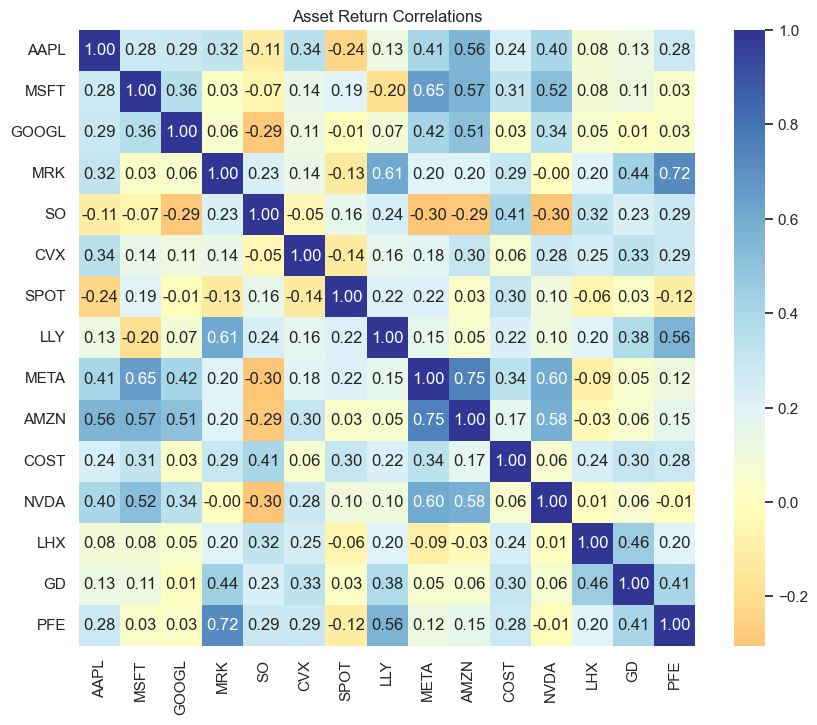


Rolling 60-day Correlations:
AAPL vs MSFT: 0.16
AAPL vs GOOGL: 0.20
AAPL vs MRK: 0.31
AAPL vs SO: -0.20
AAPL vs CVX: 0.28
AAPL vs SPOT: -0.39
AAPL vs LLY: 0.06
AAPL vs META: 0.31
AAPL vs AMZN: 0.48
AAPL vs COST: 0.14
AAPL vs NVDA: 0.34
AAPL vs LHX: 0.04
AAPL vs GD: 0.16
AAPL vs PFE: 0.25
MSFT vs GOOGL: 0.26
MSFT vs MRK: -0.03
MSFT vs SO: -0.15
MSFT vs CVX: 0.02
MSFT vs SPOT: 0.10
MSFT vs LLY: -0.37
MSFT vs META: 0.60
MSFT vs AMZN: 0.48
MSFT vs COST: 0.22
MSFT vs NVDA: 0.42
MSFT vs LHX: 0.03
MSFT vs GD: 0.08
MSFT vs PFE: -0.04
GOOGL vs MRK: 0.02
GOOGL vs SO: -0.37
GOOGL vs CVX: 0.02
GOOGL vs SPOT: -0.14
GOOGL vs LLY: -0.00
GOOGL vs META: 0.33
GOOGL vs AMZN: 0.43
GOOGL vs COST: -0.08
GOOGL vs NVDA: 0.23
GOOGL vs LHX: 0.02
GOOGL vs GD: 0.01
GOOGL vs PFE: -0.00
MRK vs SO: 0.24
MRK vs CVX: 0.13
MRK vs SPOT: -0.19
MRK vs LLY: 0.60
MRK vs META: 0.16
MRK vs AMZN: 0.19
MRK vs COST: 0.28
MRK vs NVDA: -0.08
MRK vs LHX: 0.21
MRK vs GD: 0.47
MRK vs PFE: 0.73
SO vs CVX: -0.19
SO vs SPOT: 0.12
SO vs

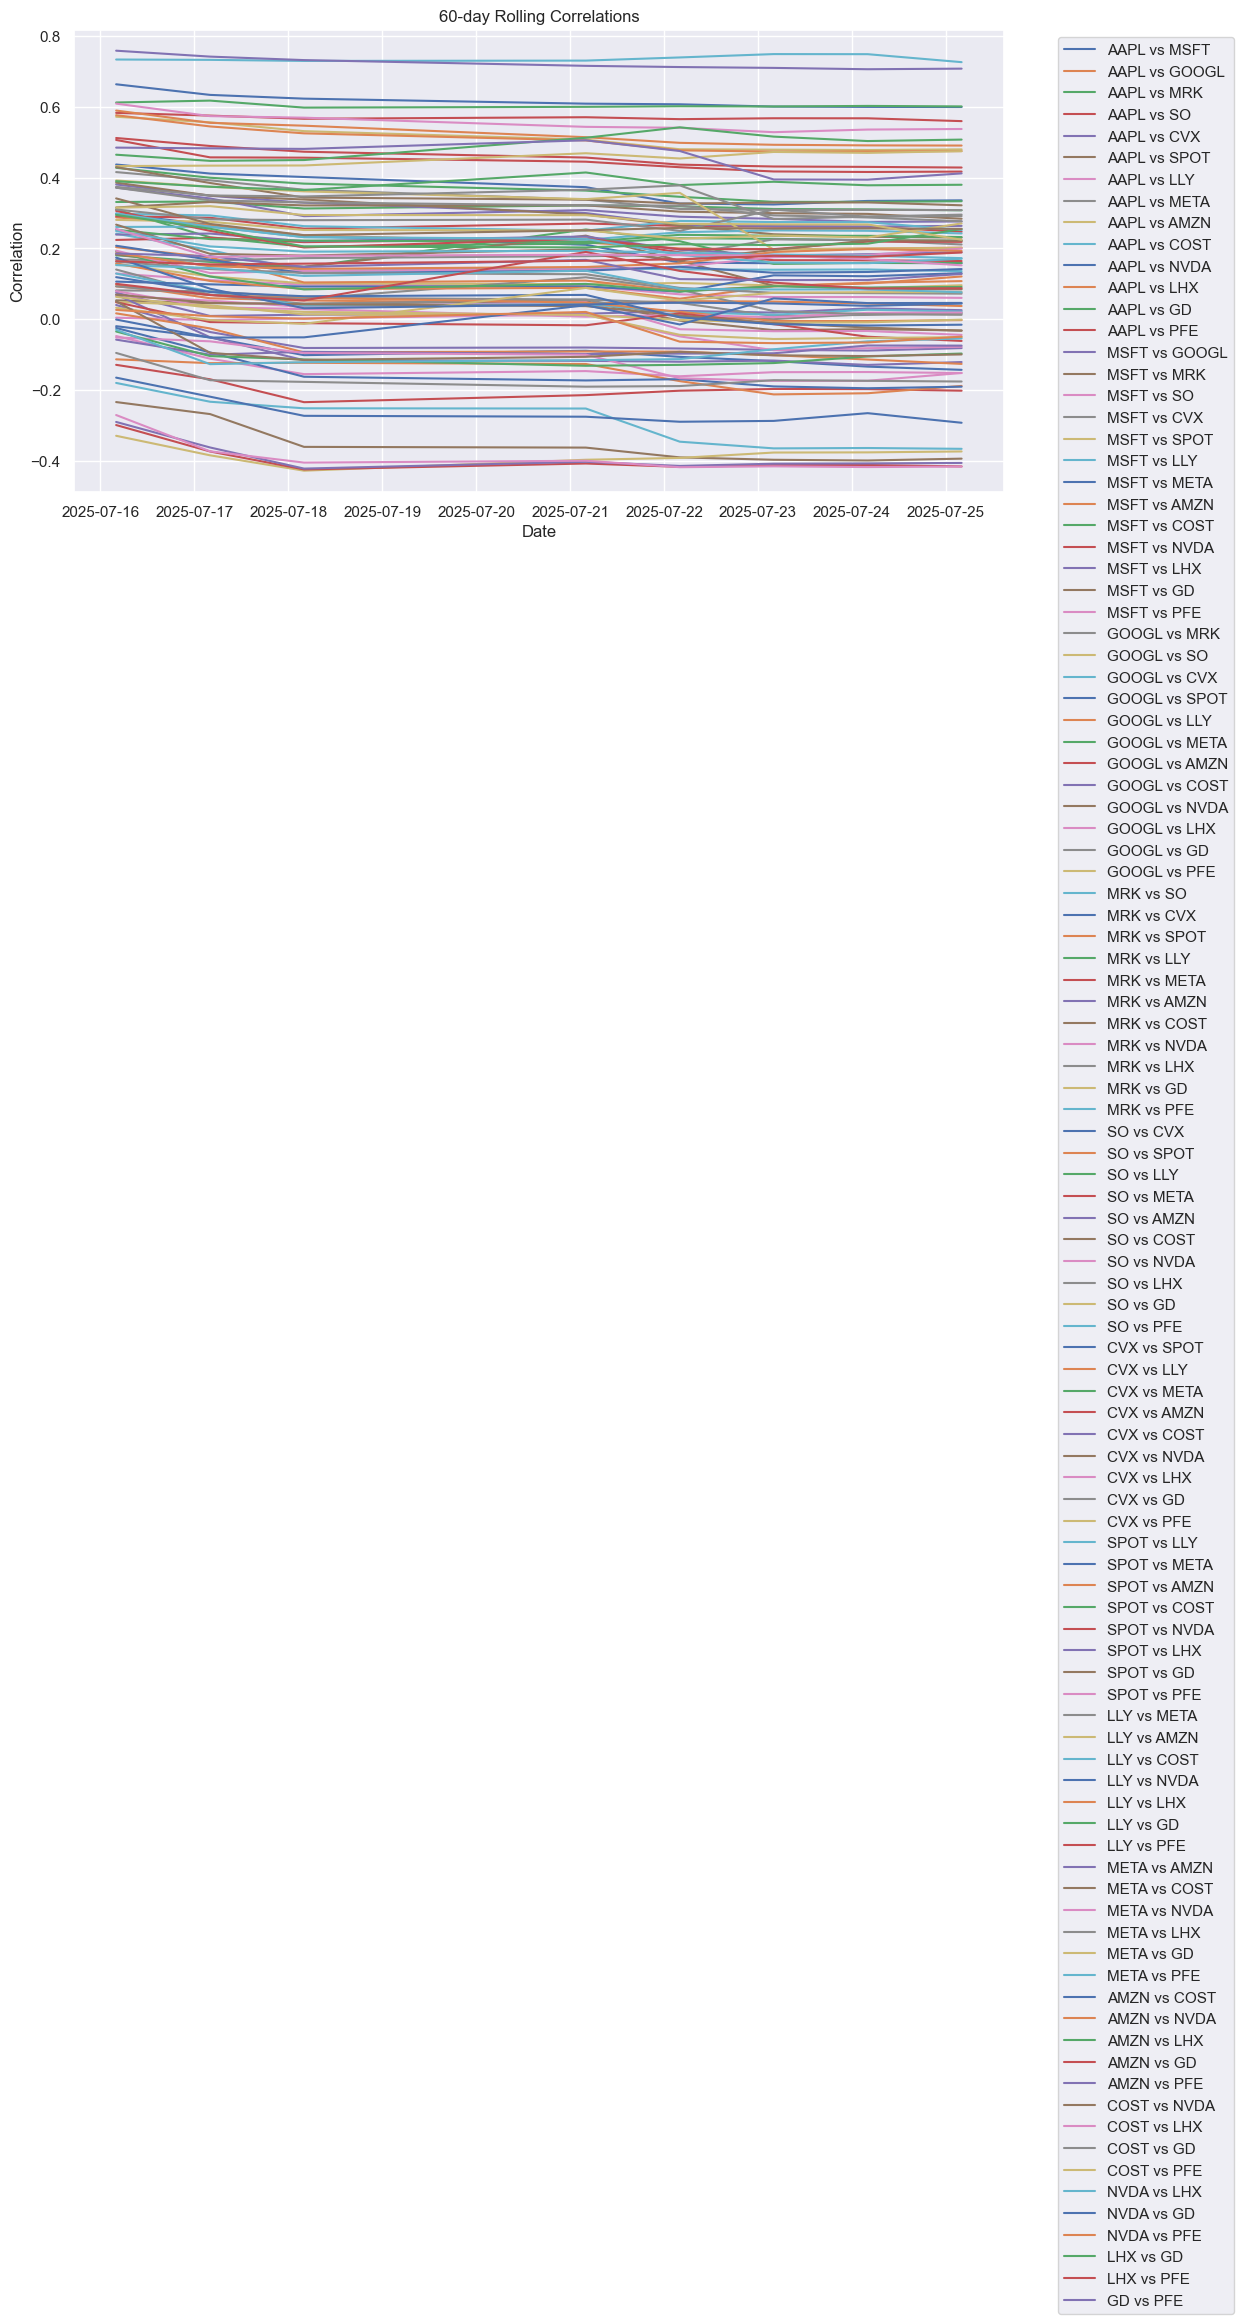

In [78]:
# Correlation analysis
print("\nCorrelation Analysis:")

# Calculate returns for each symbol
symbol_returns = {}
for symbol in symbols:
    symbol_data = historical_data.loc[symbol]
    symbol_returns[symbol] = symbol_data['close'].pct_change()

# Create returns DataFrame
returns_df = pd.DataFrame(symbol_returns)
returns_df.columns = symbols

# Calculate correlation matrix
corr_matrix = returns_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    center=0,
    cmap='RdYlBu',
    square=True
)
plt.title('Asset Return Correlations')
plt.show()

# Calculate and plot rolling correlations
print("\nRolling 60-day Correlations:")
plt.figure(figsize=(12, 6))

for i in range(len(symbols)):
    for j in range(i+1, len(symbols)):
        sym1, sym2 = symbols[i], symbols[j]
        # Calculate rolling correlation directly between pairs
        corr = returns_df[sym1].rolling(window=60).corr(returns_df[sym2])
        # Plot correlation
        sns.lineplot(data=corr, label=f"{sym1} vs {sym2}")
        # Print current correlation
        current_corr = corr.iloc[-1]
        print(f"{sym1} vs {sym2}: {current_corr:.2f}")

plt.title('60-day Rolling Correlations')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Backtest complete

Backtest Parameters:
  initial_capital: 100000
  transaction_cost: 0.001
  risk_free_rate: 0.0
  rolling_window: 60
  min_periods: 20

Alpha Strategy Info:
  Strategy: trend_momentum
  Parameters: {'fast_ma': 20, 'slow_ma': 30, 'rsi_period': 14, 'macd_fast': 12, 'macd_slow': 26, 'macd_signal': 9, 'rsi_overbought': 70, 'rsi_oversold': 30, 'smoothing': 2}


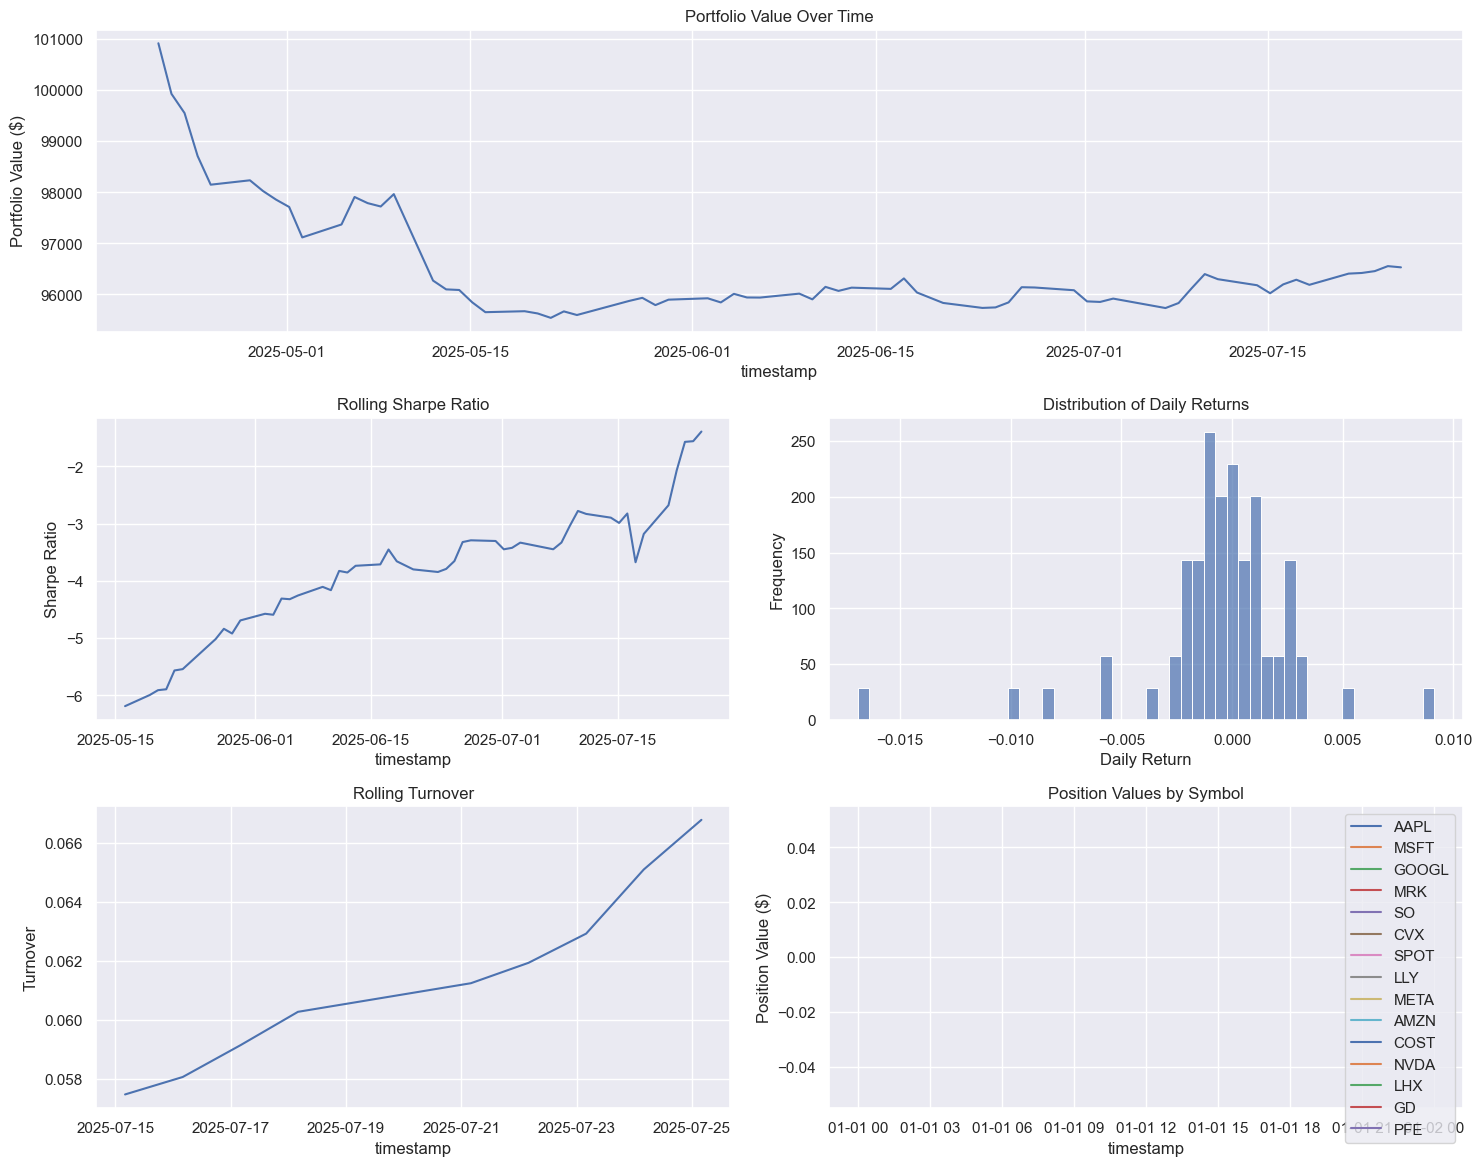


Final Portfolio Statistics:
Initial Capital: $100,000.00
Final Value: $96,531.20
Total Return: -3.47%
Sharpe Ratio: -2.42
Average Turnover: 5.98%

Position Statistics:

AAPL:
  Average Position Value: $nan
  Max Position Value: $nan
  Total PnL: $0.00
  Total Transaction Cost: $0.00
  Average Daily Turnover: nan

MSFT:
  Average Position Value: $nan
  Max Position Value: $nan
  Total PnL: $0.00
  Total Transaction Cost: $0.00
  Average Daily Turnover: nan

GOOGL:
  Average Position Value: $nan
  Max Position Value: $nan
  Total PnL: $0.00
  Total Transaction Cost: $0.00
  Average Daily Turnover: nan

MRK:
  Average Position Value: $nan
  Max Position Value: $nan
  Total PnL: $0.00
  Total Transaction Cost: $0.00
  Average Daily Turnover: nan

SO:
  Average Position Value: $nan
  Max Position Value: $nan
  Total PnL: $0.00
  Total Transaction Cost: $0.00
  Average Daily Turnover: nan

CVX:
  Average Position Value: $nan
  Max Position Value: $nan
  Total PnL: $0.00
  Total Transaction 

In [79]:
print("\nBacktest complete")
print("\nBacktest Parameters:")
for param, value in backtest_results.parameters.items():
    print(f"  {param}: {value}")

print("\nAlpha Strategy Info:")
print(f"  Strategy: {alpha_signals.metadata['function_name']}")
print(f"  Parameters: {alpha_signals.parameters}")


# Plot results
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(3, 2)

# 1. Portfolio Value
ax1 = fig.add_subplot(gs[0, :])
cumulative_pnl = backtest_results.daily_pnl.cumsum()
portfolio_value = backtest_engine.initial_capital + cumulative_pnl
sns.lineplot(data=portfolio_value, ax=ax1)
ax1.set_title('Portfolio Value Over Time')
ax1.set_ylabel('Portfolio Value ($)')
ax1.grid(True)

# 2. Rolling Sharpe Ratio
ax2 = fig.add_subplot(gs[1, 0])
if backtest_results.rolling_sharpe is not None:
    sns.lineplot(data=backtest_results.rolling_sharpe, ax=ax2)
ax2.set_title('Rolling Sharpe Ratio')
ax2.set_ylabel('Sharpe Ratio')
ax2.grid(True)

# 3. Daily Returns Distribution
ax3 = fig.add_subplot(gs[1, 1])
daily_returns = backtest_results.daily_pnl / backtest_engine.initial_capital
sns.histplot(data=daily_returns, bins=50, stat='density', alpha=0.7, ax=ax3)
ax3.set_title('Distribution of Daily Returns')
ax3.set_xlabel('Daily Return')
ax3.set_ylabel('Frequency')
ax3.grid(True)

# 4. Rolling Turnover
ax4 = fig.add_subplot(gs[2, 0])
if backtest_results.rolling_turnover is not None:
    sns.lineplot(data=backtest_results.rolling_turnover, ax=ax4)
ax4.set_title('Rolling Turnover')
ax4.set_ylabel('Turnover')
ax4.grid(True)

# 5. Position Values by Symbol
ax5 = fig.add_subplot(gs[2, 1])
for symbol in symbols:
    position_values = backtest_results.positions.loc[symbol, 'position_value']
    sns.lineplot(data=position_values, label=symbol, ax=ax5)
ax5.set_title('Position Values by Symbol')
ax5.set_ylabel('Position Value ($)')
ax5.legend()
ax5.grid(True)

plt.tight_layout()
plt.show()

# Print final statistics
print("\nFinal Portfolio Statistics:")
print(f"Initial Capital: ${backtest_engine.initial_capital:,.2f}")
print(f"Final Value: ${portfolio_value.iloc[-1]:,.2f}")
print(f"Total Return: {((portfolio_value.iloc[-1] / backtest_engine.initial_capital) - 1):.2%}")
print(f"Sharpe Ratio: {backtest_results.sharpe_ratio:.2f}")
print(f"Average Turnover: {backtest_results.avg_turnover:.2%}")

# Position statistics
print("\nPosition Statistics:")
for symbol in symbols:
    pos = backtest_results.positions.loc[symbol]
    print(f"\n{symbol}:")
    print(f"  Average Position Value: ${pos['position_value'].mean():,.2f}")
    print(f"  Max Position Value: ${pos['position_value'].max():,.2f}")
    print(f"  Total PnL: ${pos['daily_pnl'].sum():,.2f}")
    print(f"  Total Transaction Cost: ${pos['transaction_cost'].sum():,.2f}")
    print(f"  Average Daily Turnover: {pos['turnover'].mean():,.2f}")


Signal Performance Analysis:

AAPL Signal Analysis:

Signal Distribution:
count    68.000000
mean     -0.041912
std       0.527923
min      -0.700000
25%      -0.400000
50%      -0.400000
75%       0.400000
max       0.700000
Name: signal, dtype: float64

Signal Changes: 10
Average Hold Period: 6.80 periods

Component Correlations with Returns:
fast_ma: -0.149
slow_ma: 0.058
rsi: 0.080
macd: 0.097
macd_hist: 0.142
signal: -0.030

Signal Effectiveness:
Positive Signals:
  Count: 26
  Avg Next Return: -0.131%
  % Profitable: 42.3%

Negative Signals:
  Count: 40
  Avg Next Return: 0.168%
  % Profitable: 30.0%

Potential Issues:
MA Crossover Persistence: 0.895
RSI Extreme Readings: Overbought 0, Oversold 0
MACD Direction Changes: 2

MSFT Signal Analysis:

Signal Distribution:
count    68.000000
mean     -0.208824
std       0.212122
min      -0.700000
25%      -0.400000
50%      -0.200000
75%      -0.162500
max       0.100000
Name: signal, dtype: float64

Signal Changes: 10
Average Hold Pe

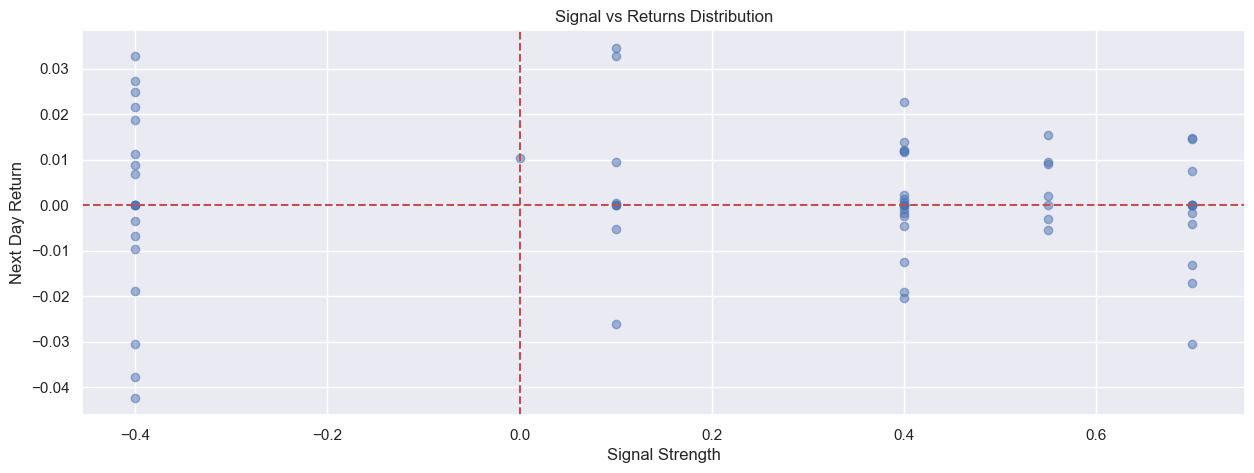

In [80]:
# Signal quality analysis
print("\nSignal Performance Analysis:")

# Calculate daily returns for analysis
symbol_daily_returns = {}
for symbol in symbols:
    # Resample to daily and calculate returns
    daily_data = historical_data.loc[symbol].resample('D').last()
    daily_returns = daily_data['close'].pct_change()
    symbol_daily_returns[symbol] = daily_returns

# Analyze signal components and their predictive power
for symbol in symbols:
    print(f"\n{symbol} Signal Analysis:")
    
    # Get symbol data
    symbol_signals = alpha_signals.signals.loc[symbol]
    
    # 1. Signal Distribution
    print("\nSignal Distribution:")
    print(symbol_signals['signal'].describe())
    
    # 2. Signal Transitions
    signal_changes = symbol_signals['signal'].diff().fillna(0)
    transitions = len(signal_changes[signal_changes != 0])
    print(f"\nSignal Changes: {transitions}")
    print(f"Average Hold Period: {len(symbol_signals)/transitions:.2f} periods")
    
    # 3. Component Analysis
    print("\nComponent Correlations with Returns:")
    daily_signals = symbol_signals.resample('D').last()
    daily_rets = symbol_daily_returns[symbol]
    
    # Align data
    common_idx = daily_signals.index.intersection(daily_rets.index)
    signals = daily_signals.loc[common_idx]
    returns = daily_rets.loc[common_idx]
    
    # Calculate forward returns (next day's return)
    forward_returns = returns.shift(-1)
    
    components = ['fast_ma', 'slow_ma', 'rsi', 'macd', 'macd_hist', 'signal']
    for component in components:
        if component in signals.columns:
            corr = signals[component].corr(forward_returns)
            print(f"{component}: {corr:.3f}")
    
    # 4. Signal Effectiveness
    # Split signals into positive and negative
    pos_signals = signals[signals['signal'] > 0]
    neg_signals = signals[signals['signal'] < 0]
    
    # Calculate next-day returns for each signal type
    pos_next_returns = forward_returns[signals['signal'] > 0]
    neg_next_returns = forward_returns[signals['signal'] < 0]
    
    print("\nSignal Effectiveness:")
    print(f"Positive Signals:")
    print(f"  Count: {len(pos_signals)}")
    print(f"  Avg Next Return: {pos_next_returns.mean():.3%}")
    print(f"  % Profitable: {(pos_next_returns > 0).mean():.1%}")
    
    print(f"\nNegative Signals:")
    print(f"  Count: {len(neg_signals)}")
    print(f"  Avg Next Return: {neg_next_returns.mean():.3%}")
    print(f"  % Profitable: {(neg_next_returns < 0).mean():.1%}")
    
    # 5. Check for potential issues
    print("\nPotential Issues:")
    # Look for mean reversion in MA signals
    ma_cross = symbol_signals['fast_ma'] - symbol_signals['slow_ma']
    ma_persist = ma_cross.autocorr()
    print(f"MA Crossover Persistence: {ma_persist:.3f}")
    
    # Check RSI effectiveness
    rsi = symbol_signals['rsi']
    rsi_overbought = rsi[rsi > 70]
    rsi_oversold = rsi[rsi < 30]
    print(f"RSI Extreme Readings: Overbought {len(rsi_overbought)}, Oversold {len(rsi_oversold)}")
    
    # MACD signal quality
    macd_changes = np.sign(symbol_signals['macd_hist']).diff().fillna(0)
    macd_switches = len(macd_changes[macd_changes != 0])
    print(f"MACD Direction Changes: {macd_switches}")

plt.figure(figsize=(15, 5))
plt.title("Signal vs Returns Distribution")
plt.scatter(signals['signal'], forward_returns, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel("Signal Strength")
plt.ylabel("Next Day Return")
plt.grid(True)
plt.show()

In [15]:
from edgar import *
from env import edgar_identity

# Set Edgar identity for API access
set_identity(edgar_identity)

# Example usage of Edgar API
# Get company filings
filings = Company("AMZN").get_filings()

insider_filings = filings.filter(form="4")

print("\nRecent Insider Filings for GOOGL:")
print(insider_filings[0].obj())


Recent Insider Filings for GOOGL:


╭──────────────────────────────────────── Ownership Transactions (Sale)  ─────────────────────────────────────────╮
│ Insider:  Jeffrey P Bezos                                                                                       │
│ Position: Executive Chair                                                                                       │
│ Company:  AMAZON COM INC (AMZN)                                                                                 │
│ Date:     2025-07-23                                                                                            │
│ Form:     Form 4                                                                                                │
│                                 Common Stock Transactions                                                       │
│                                                                                                                 │
│   Type             Code   Description            Shares   Price/Share 